In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli

In [13]:
# Generates rewards matrix of size (2, ktrials, Nflies)
# rb has rewards of value coeff_r and 0, and ry is a multiple of rb (the double if reward_quotient is set at 2)

def create_rewards(ktrials,Nflies):
    r=np.random.randint(0,2,size=(ktrials,Nflies))
    
    rb=coeff_r*r
    ry=reward_quotient*rb 
    
    rewards=np.asarray(np.empty((2,ktrials,Nflies)))
    rewards[0]=rb
    rewards[1]=ry
    return (rewards)

In [14]:
# Generates choice array  of size Nflies

def choice (mb,my):
    Py = np.exp(beta * my) / (np.exp(beta * my) + np.exp(beta * mb))
        
    cy = bernoulli.rvs(Py)
    cb = - cy +1
    return [cb,cy]

In [15]:
# Returns the estimated and effective rewards, and the energy spent.
# Respectively 2 arrays of size Nflies, an array of size (ktrials,Nflies) and an array of size Nflies

def r_E_calcul(cb,cy,r_E_variables,rewards,i):
    r_E_variables["expected_rb"] = (1 - lambda_r * cb) * r_E_variables["expected_rb"] + lambda_r*rewards[0][i] * cb
    r_E_variables["expected_ry"] = (1 - lambda_r * cy) * r_E_variables["expected_ry"] + lambda_r*rewards[1][i] * cy
    
    r_E_variables["E"] = r_E_variables["E"] + (abs(r_E_variables["dmb"]) + abs(r_E_variables["dmy"]))*energy_factor
    
    r_E_variables["reward_received"][i] = rewards[0][i]*cb+rewards[1][i]*cy
      
    return[r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]

In [16]:
# Generates an array of the weights at each time step, of size (2,ktrials)

def weights(rewards, beta, eps, lambda_r, lambda_ARM):
    m_max=1
    x=1
    
    mb = np.zeros(Nflies)
    my = np.zeros(Nflies)
    
    r_E_variables = { "expected_rb" : np.zeros(Nflies),
                    "expected_ry" : np.zeros(Nflies),
                    "reward_received" : np.empty((ktrials,Nflies)),
                    "E" : np.zeros(Nflies)}
    
    weights = np.empty((2,ktrials,Nflies))
    expected_rewards = np.empty((2,ktrials))
    
    for i in range (ktrials) :
        
        [cb,cy]=choice(mb,my)
        
        mb -= mb * lambda_ARM
        r_E_variables["dmb"] = cb * eps * (rewards[0][i] - r_E_variables["expected_rb"]) * (x - mb/m_max)
        
        b_positive_correction=np.where(mb + r_E_variables["dmb"] < 0)
        r_E_variables["dmb"][b_positive_correction]= 0 - mb[b_positive_correction]
        
        b_max_correction=np.where(mb + r_E_variables["dmb"] > m_max)
        r_E_variables["dmb"][b_max_correction]= m_max - mb[b_max_correction]
        
        mb += r_E_variables["dmb"]
        
        my -= my * lambda_ARM
        r_E_variables["dmy"] = cy * eps * (rewards[1][i] - r_E_variables["expected_ry"]) * (x - my/m_max)
        
        y_positive_correction=np.where(my + r_E_variables["dmy"] < 0)
        r_E_variables["dmy"][y_positive_correction]= 0 - my[y_positive_correction]
        
        y_max_correction=np.where(my + r_E_variables["dmy"] > m_max)
        r_E_variables["dmy"][y_max_correction]= m_max - my[y_max_correction]
        
        my += r_E_variables["dmy"]
    
        [r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]=r_E_calcul(cb,cy,r_E_variables,rewards,i)
        
        weights[0,i] = mb
        weights[1,i] = my
        expected_rewards[0,i] = sum(r_E_variables["expected_rb"])
        expected_rewards[1,i] = sum(r_E_variables["expected_ry"])
    return weights

In [17]:
#Parameters setting
Nflies = 100
ktrials = 200
lambda_r=0.1
beta=7
eps = 0.0001
coeff_r = 0.02
reward_quotient = 2
energy_factor = 30

([<matplotlib.axis.YTick at 0x7fcf01d7ebb0>,
 [Text(0, 0.0, '0'),
  Text(0, 3e-06, '0.000003'),
  Text(0, 6e-06, '0.000006'),
  Text(0, 9e-06, '0.000009'),
  Text(0, 1.2e-05, '0.000012'),
  Text(0, 1.5e-05, '0.000015')])

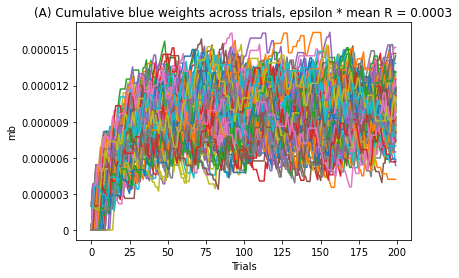

In [18]:
# Plot of the cumulative blue weights as a function of trials, for each fly
for i in range (Nflies):
    plt.plot(weights(create_rewards(ktrials,Nflies), beta, eps, lambda_r, 0)[0,:,i])
plt.xlabel("Trials")
plt.ylabel("mb")
plt.title("(A) Cumulative blue weights across trials, epsilon * mean R = 0.0003")
plt.yticks([0,0.000003,0.000006,0.000009,0.000012,0.000015],["0","0.000003","0.000006","0.000009","0.000012","0.000015"])


In [ ]:
# Plot of the yellow weights as a function of trials, for each fly
for i in range (Nflies):
    plt.plot(weights(create_rewards(ktrials,Nflies), beta, eps, lambda_r, 0)[1,:,i])
plt.xlabel("Trials")
plt.ylabel("my")
plt.title("(B) Yellow weights across trials, epsilon * mean R = 0.0003")
plt.yticks([0,0.000006,0.000012,0.000018,0.000024,0.00003],["0","0.000006","0.000012","0.000018","0.000024","0.00003"])